<a href="https://colab.research.google.com/github/shrutikakubal/KG/blob/main/kg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install spacy-transformers
import spacy
#BERT
!python -m spacy download en_core_web_trf
!pip install accelerate
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.1 MB/s eta 0:00:00


In [1]:
import spacy
nlp = spacy.load('en_core_web_trf')
doc = nlp("Apple shares rose on the news. Apple pie is delicious.")
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
# Extract named entities
entities = [(ent.text, ent.label_) for ent in doc.ents]
# Print results
if entities:
   print("NamedEntities:")
   for entity, label in entities:
       print(f"{entity} - {label}")
else:
  print("No named entities found in the sentence.")
for tok in doc:
    print(tok.text, "...", tok.dep_)

NamedEntities:
Apple - ORG
Apple ... compound
shares ... nsubj
rose ... ROOT
on ... prep
the ... det
news ... pobj
. ... punct
Apple ... compound
pie ... nsubj
is ... ROOT
delicious ... acomp
. ... punct


In [2]:
#entity pair extraction
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence
    prev_subject = "" # prev subject
    prev_object = "" # prev object

    prefix = ""
    modifier = ""
    label = ""

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier (adjective, quantifier, "very" before "very quickly") or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it (e.g. "goodbye, highrise")
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3 - find subject (entity one)
            if tok.dep_.find("subj") == True:
              if tok.pos_=="PRON" and prev_subject!="":
                ent1 = prev_subject
              else:
                ent1 = modifier + " " + prefix + " " + tok.text
              prefix = ""
              modifier = ""
              prv_tok_dep = ""
              prv_tok_text = ""
              prev_subject = ent1

                ## chunk 4 - find object (entity two)
            if tok.dep_.find("obj") == True:
              if tok.pos_=="PRON" and prev_object!="":
                ent2 = prev_object
              else:
                ent2 = modifier + " " + prefix + " " + tok.text
                prev_object = ent2

              ## chunk 6 - add label
            if tok.dep_ != "ROOT" and prv_tok_dep == "dobj" and tok.dep_== "acl":
              for child in tok.children:
              # Check if the dependent is an adjective clause modifier
                if child.dep_ == "oprd":
                  subtree_text = ""
                  for sub_token in child.subtree:
                    if not sub_token.is_punct:
                      subtree_text += sub_token.text + " "
            # Print the dependent and its subtree
                    label = subtree_text.strip()
                if ent2!="":
                  ent2 = ent2 + " " + tok.text + " " + label
                  prev_object = ent2

            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    #############################################################
    return [ent1.strip(), ent2.strip()]


def  get_relation(sent):

    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    #find root, prepositional modifier, agent (do-er), adjective
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1",[pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    #last matching substring
    span = doc[matches[k][1]:matches[k][2]]

    return(span.text)

In [3]:
def split_sentence_by_nsubj(sentence):
    # Parse the sentence with spaCy
    doc = nlp(sentence)

    # Initialize variables to store sentence parts
    sentence_parts = []
    current_part = []

    # Iterate through the tokens
    for token in doc:
        # If the token is a subject, start a new part
        if token.dep_ == "nsubj":
            if current_part:
                sentence_parts.append(" ".join(current_part))
                current_part = []
        # Add token to the current part
        current_part.append(token.text)

    # Add the last part to the list
    if current_part:
        sentence_parts.append(" ".join(current_part))

    return sentence_parts

def split_sentence(sentence):
    # Parse the sentence with spaCy
    doc = nlp(sentence)

    # Initialize variables to store sentence parts
    sentence_parts = []
    subject_indices = []
# Find the subject and verb indices
    for token in doc:
        if token.dep_ == "nsubj":
            subject_indices.append(token.i)
    # If both subject and verb are found, split the sentence
    if(len(subject_indices)>1):
      for j in range(len(subject_indices)-1):
        # Split the sentence into two parts
        if doc[subject_indices[j+1]].pos_=="PRON":
          text = " ".join([token.text for token in doc[subject_indices[j]:subject_indices[j+1]]])
        else:
          text = " ".join([token.text for token in doc[subject_indices[j]:subject_indices[j+1]+1]])
        sentence_parts.append(text)

      text = " ".join([token.text for token in doc[subject_indices[j+1]:]])
      sentence_parts.append(text)
      return sentence_parts
    else:
      return sentence

In [4]:
#print(get_entities("what did lions gate entertainment produce? They produced bambi."))
#get_relation("the film is narrated by chiranjeevi.")

#split_sentence_by_nsubj("what did lions gate entertainment produce? They produced bambi.")
doc=nlp("Alice finds a fan that enables her to shrink enough to get into the Garden")
for tok in doc:
    print(tok.text, "...", tok.dep_, "...", tok.pos_,)
print(split_sentence("Alice finds a fan that enables her to shrink enough to get into the Garden"))

Alice ... nsubj ... PROPN
finds ... ROOT ... VERB
a ... det ... DET
fan ... dobj ... NOUN
that ... nsubj ... PRON
enables ... relcl ... VERB
her ... dobj ... PRON
to ... aux ... PART
shrink ... xcomp ... VERB
enough ... advmod ... ADV
to ... aux ... PART
get ... xcomp ... VERB
into ... prep ... ADP
the ... det ... DET
Garden ... pobj ... PROPN
['Alice finds a fan', 'that enables her to shrink enough to get into the Garden']


In [5]:
# Access the named entity recognizer (NER) component
ner = nlp.get_pipe("ner")

# Get all the entity types recognized by the model
entity_types = ner.labels

# Print the entity types
print("Entity types:", entity_types)

Entity types: ('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


In [6]:
import pandas as pd
paragraph = 'Alice follows a large white rabbit down a "Rabbit-hole". Alice finds a tiny door. When Alice finds a bottle labeled "Drink me", she does. Alice shrinks, but not enough to pass through the door. Alice then eats something labeled "Eat me" and grows larger. Alice finds a fan. that enables her to shrink enough to get into the "Garden". Alice tries to get a "Dog" to play with her. She enters the "White Rabbits tiny House," but suddenly resumes her normal size. In order to get out, she has to use the "magic fan."'
# Split paragraph into sentences by punctuation
sentences = paragraph.split('. ')

# Create DataFrame
sents = pd.DataFrame({'Sentence': sentences})

# Print DataFrame
print(sents)
doc=nlp("Alice tries to get a 'Dog' to play with her")
for tok in doc:
    print(tok.text, "...", tok.dep_, "...", tok.pos_,)



                                            Sentence
0  Alice follows a large white rabbit down a "Rab...
1                            Alice finds a tiny door
2  When Alice finds a bottle labeled "Drink me", ...
3  Alice shrinks, but not enough to pass through ...
4  Alice then eats something labeled "Eat me" and...
5                                  Alice finds a fan
6  that enables her to shrink enough to get into ...
7        Alice tries to get a "Dog" to play with her
8  She enters the "White Rabbits tiny House," but...
9  In order to get out, she has to use the "magic...
Alice ... nsubj ... PROPN
tries ... ROOT ... VERB
to ... aux ... PART
get ... xcomp ... VERB
a ... det ... DET
' ... punct ... PUNCT
Dog ... nsubj ... NOUN
' ... punct ... PUNCT
to ... aux ... PART
play ... ccomp ... VERB
with ... prep ... ADP
her ... pobj ... PRON


In [7]:
entity_pairs = []

for i in sents["Sentence"]:
    entity_pairs.append(get_entities(i))
relations = [get_relation(i) for i in sents["Sentence"]]


In [8]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'edge':relations, 'target':target})
print(kg_df)

        source     edge                          target
0        Alice  follows               white Rabbit hole
1        Alice    finds                      tiny  door
2  When  Alice     does         bottle labeled Drink me
3        Alice  shrinks                    enough  door
4        Alice     eats  then  something labeled Eat me
5        Alice    finds                             fan
6         that  enables                  enough  Garden
7          Dog    tries                             her
8          She   enters                    normal  size
9          she      has                      magic  fan


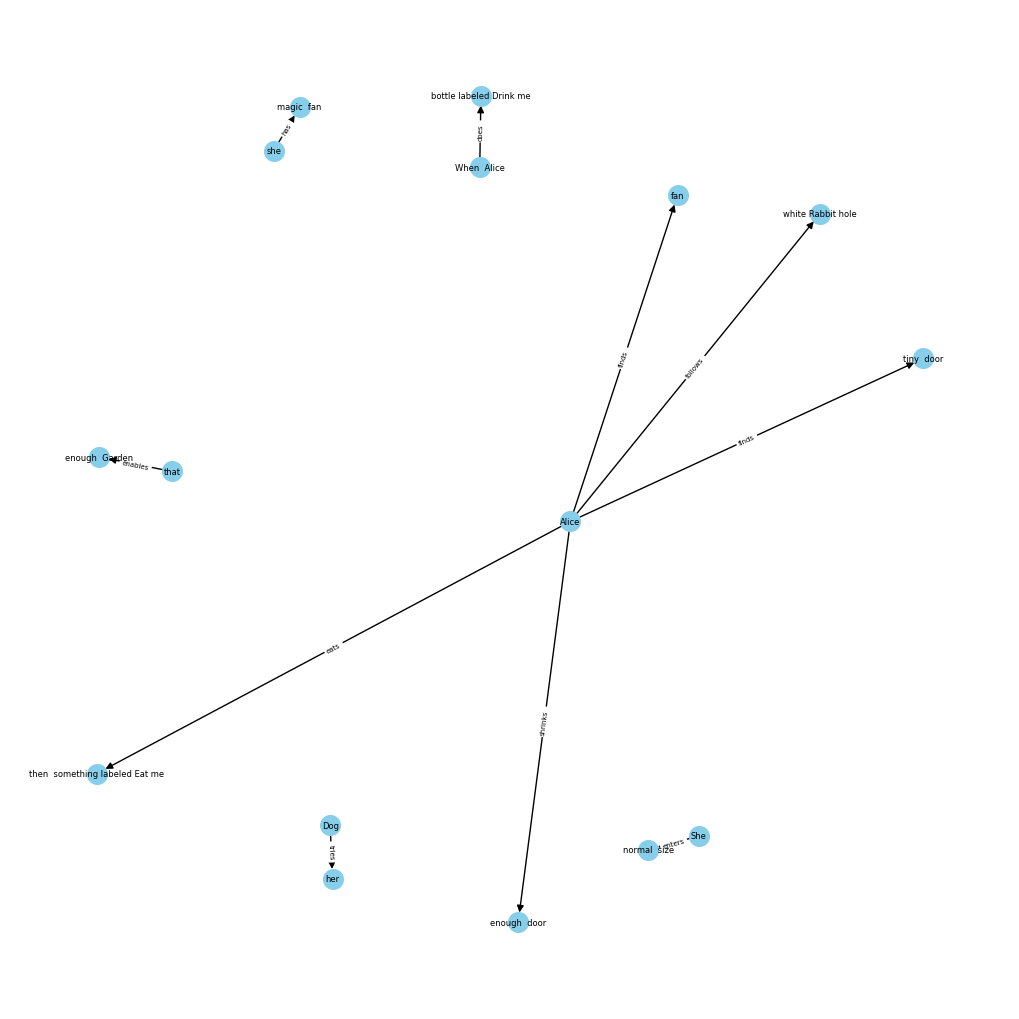

In [9]:
#create graph
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos, node_size=200, font_size=6)
edge_labels = {(source, target): attr['edge'] for source, target, attr in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=5)

plt.show()


In [10]:
sentence = "When Alice finds a bottle labeled 'Drink me', she does."
#!pip install spacy-transformers
#nlp = spacy.load('en_core_web_trf')
# Iterate through the tokens
for token in doc:
    # If the token is the main verb ("finds")
    if token.dep_ != "ROOT":
# Iterate through the root token's children
      for child in token.children:
        # Check if the dependent is an adjective clause modifier
        if child.dep_ == "acl":
            # Print the dependent and its subtree
            #print(token, token.dep_, child.text, [(sub_token.text, sub_token.dep_, sub_token.pos_) for sub_token in child.subtree if sub_token.is_punct == False])
            subtree_text = ""
            for sub_token in child.subtree:
                if not sub_token.is_punct:
                    subtree_text += sub_token.text + " "
            # Print the dependent and its subtree
            #print(subtree_text.strip())


In [11]:
triples = kg_df.apply(lambda row: '; '.join(row), axis=1).tolist()
context = "("+"),(".join(triples)

print(context)

(Alice; follows; white Rabbit hole),(Alice; finds; tiny  door),(When  Alice; does; bottle labeled Drink me),(Alice; shrinks; enough  door),(Alice; eats; then  something labeled Eat me),(Alice; finds; fan),(that; enables; enough  Garden),(Dog; tries; her),(She; enters; normal  size),(she; has; magic  fan


In [12]:
import torch
#from constants import MAX_NEW_TOKENS, MODEL_FAMILY_DICT
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_FAMILY_DICT = {
    # embeddings
    "text-embedding-ada-002": "openai",
    "all-MiniLM-L6-v2": "sentence-transformers",
    "BAAI/bge-base-en-v1.5": "sentence-transformers",
    "BAAI/bge-large-en-v1.5": "sentence-transformers",
    # generators
    "gpt-35-turbo": "openai",
    "gpt-35-turbo-16k": "openai",
    "gpt-4": "openai",
    "gpt-4-0613": "openai",
    "mistralai/Mistral-7B-v0.1": "transformers",
    "mistralai/Mistral-7B-Instruct-v0.1": "transformers",
    "mistralai/Mistral-7B-Instruct-v0.2": "transformers",
    "mistralai/Mixtral-8x7B-Instruct-v0.1": "transformers",
    "microsoft/phi-2": "transformers",
    "gemini-pro": "google",
}

def HuggingFaceGenerator(model_name, MAX_NEW_TOKENS):
  max_new_tokens = MAX_NEW_TOKENS

        # model = self.generator_name
        # # model = "mistralai/Mixtral-8x7B-Instruct-v0.1"
  tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
  model = AutoModelForCausalLM.from_pretrained(
            model_name,
           load_in_4bit=True,
            torch_dtype=torch.float16,
            bnb_4bit_compute_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True,
            )

def HuggingGenerate(prompt, max_length=100, num_return_sequences=1):
  inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
  outputs = self.model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=self.tokenizer.eos_token_id,
        )
  answer = self.tokenizer.batch_decode(outputs)[0][len(prompt):]
  return answer

In [13]:

triples = kg_df.apply(lambda row: '; '.join(row), axis=1).tolist()
context = "("+"),(".join(triples)

# Generator
model_name="mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
            model_name,
           load_in_4bit=True,
            torch_dtype=torch.float16,
            bnb_4bit_compute_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True,
            )
while True:
    query = input("Ask a question: ")
    if query == "exit":
      break

    from pprint import pprint
    pprint(context)

    RAG_prompt = f"""You are an assistant for question-answering tasks.
            The context is given to you in the form of (source; relation; target).
            If you don't know the answer, just say that you don't know.
            Use only the context to answer.
            Question: {query}
            Context: {context}
            Answer:
        """
    #answer = generator.generate(RAG_prompt)
    inputs = tokenizer(RAG_prompt, return_tensors="pt")
    outputs = model.generate(
            **inputs,
            max_new_tokens=32,
            pad_token_id=tokenizer.eos_token_id,
        )
    answer = tokenizer.batch_decode(outputs)[0][len(RAG_prompt):]
    print(answer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Ask a question: what did alice find?
('(Alice; follows; white Rabbit hole),(Alice; finds; tiny  door),(When  Alice; '
 'does; bottle labeled Drink me),(Alice; shrinks; enough  door),(Alice; eats; '
 'then  something labeled Eat me),(Alice; finds; fan),(that; enables; enough  '
 'Garden),(Dog; tries; her),(She; enters; normal  size),(she; has; magic  fan')


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


     Alice found a tiny door, a bottle labeled Drink me, something labeled Eat me, a fan that enabled her to enter the normal size, and a
Ask a question: what kind of fan is it?
('(Alice; follows; white Rabbit hole),(Alice; finds; tiny  door),(When  Alice; '
 'does; bottle labeled Drink me),(Alice; shrinks; enough  door),(Alice; eats; '
 'then  something labeled Eat me),(Alice; finds; fan),(that; enables; enough  '
 'Garden),(Dog; tries; her),(She; enters; normal  size),(she; has; magic  fan')
     It is a magic fan.</s>
Ask a question: how does she fit through the door?
('(Alice; follows; white Rabbit hole),(Alice; finds; tiny  door),(When  Alice; '
 'does; bottle labeled Drink me),(Alice; shrinks; enough  door),(Alice; eats; '
 'then  something labeled Eat me),(Alice; finds; fan),(that; enables; enough  '
 'Garden),(Dog; tries; her),(She; enters; normal  size),(she; has; magic  fan')
     Alice finds a tiny door and drinks a bottle labeled "Drink me". She then eats something labeled 